## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root_dir not in sys.path:
    sys.path.insert(0, root_dir)

In [3]:
import gymnasium as gym
from diffuser.utils.config import Config, get_params, get_device_settings
from diffuser.utils.training import Trainer
from diffuser.utils.arrays import report_parameters, batchify

import collections
import numpy as np
import pdb
from minari import DataCollector, StepDataCallback
import torch
import sys
import matplotlib.pyplot as plt
import h5py
from datetime import datetime
import wandb

## Parse Arguments and Paramters

In [ ]:
# Get settings from the config file

parser = get_params()

args = parser.parse_known_args(sys.argv[1:])[0]

# Set Seeds
seed = args.seed
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Get device settings
device = get_device_settings(args)

In [ ]:
dataset_config = Config(
    args.loader,
    savepath=(args.savepath, "dataset_config.pkl"),
    env=args.env_name,
    horizon=args.horizon,
    normalizer=args.normalizer,
    preprocess_fns=args.preprocess_fns,
    use_padding=args.use_padding,
    max_path_length=args.max_path_length,
)

render_config = Config(
    args.renderer,
    savepath=(args.savepath, "render_config.pkl"),
    env=args.env_name,
)

model_config = Config(
    args.model,
    savepath=(args.savepath, "model_config.pkl"),
    horizon=args.horizon,
    transition_dim=args.observation_dim + args.action_dim,
    cond_dim=args.observation_dim,
    dim_mults=args.dim_mults,
    device=device,
)
diffusion_config = Config(
    _class="models.diffuser.GaussianDiffusion",
    savepath=(args.savepath, "diffusion_config.pkl"),
    horizon=args.horizon,
    observation_dim=args.observation_dim,
    action_dim=args.action_dim,
    n_timesteps=args.n_timesteps,
    loss_type=args.loss_type,
    clip_denoised=args.clip_denoised,
    predict_epsilon=args.predict_epsilon,
    # loss weighting
    action_weight=args.action_weight,
    loss_weights=args.loss_weights,
    loss_discount=args.loss_discount,
    device=device,
)

trainer_config = Config(
    Trainer,
    savepath=(args.savepath, "trainer_config.pkl"),
    train_batch_size=args.train_batch_size,
    train_lr=args.train_lr,
    name=args.env_name,
    gradient_accumulate_every=args.gradient_accumulate_every,
    ema_decay=args.ema_decay,
    sample_freq=args.sample_freq,
    save_freq=args.save_freq,
    label_freq=args.label_freq,
    save_parallel=args.save_parallel,
    results_folder=args.savepath,
    bucket=args.bucket,
    n_reference=args.n_reference,
    n_samples=args.n_samples,
    device=device,
)

In [ ]:
# Load objects
dataset = dataset_config()
renderer = render_config()
model = model_config()
diffuser = diffusion_config(model)
trainer = trainer_config(diffuser, dataset, renderer, device)

## Forward pass is working

In [ ]:
report_parameters(model)

print("Testing forward...", end=" ", flush=True)
batch = batchify(dataset[0])
loss, _ = diffuser.loss(*batch)
loss.backward()
print("✓")

## Using the trainer requires taking care of the 'device' in the folders

# Training process inlcluding rendering

In [ ]:
current_time = datetime.now().strftime("%d_%m_%Y-%H-%M")

if args.use_wandb:
    run = wandb.init(
        config=args,
        project=args.wandb_project,
        entity=args.wandb_entity,
        name=f"Run_{current_time}",
        group="Group-Name",
        job_type="training",
        reinit=True,
    )

In [ ]:
from tqdm import tqdm

# n_epochs = int(args.n_train_steps // args.n_steps_per_epoch)
n_epochs = 5
diffuser.to(device)
for i in tqdm(range(n_epochs)):
    print(f"Epoch {i} / {n_epochs} | {args.savepath}")
    trainer.train(n_train_steps=10000)

In [ ]:
from tqdm import tqdm

# n_epochs = int(args.n_train_steps // args.n_steps_per_epoch)
n_epochs = 5
diffuser.to(device)
for i in tqdm(range(n_epochs)):
    print(f"Epoch {i} / {n_epochs} | {args.savepath}")
    trainer.train(n_train_steps=10000)

Observations shape: (4000000, 4)
Qpos shape: (4000000, 2)


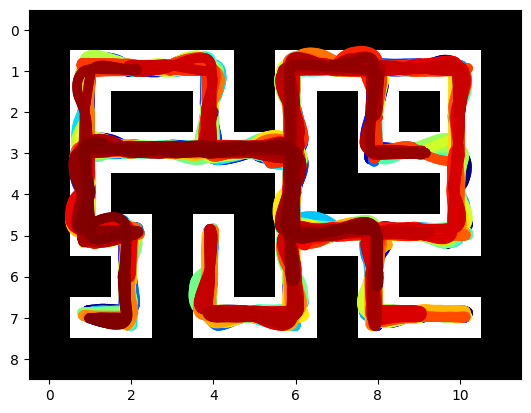

In [4]:
def extract_datasets(file_path):
    with h5py.File(file_path, "r") as f:
        # Extract observations dataset
        observations = np.array(f["observations"])

        # Extract infos/qpos dataset
        qpos = np.array(f["infos/qpos"])

    return observations, qpos


# Replace 'your_file_path_here' with the actual path to the HDF5 file
file_path = "/Users/magic-rabbit/Downloads/maze2d-large-dense-v1.hdf5"
observations, qpos = extract_datasets(file_path)

# Printing shapes of the arrays to confirm extraction
print("Observations shape:", observations.shape)
print("Qpos shape:", qpos.shape)

LARGE_MAZE = [
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
    [1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
    [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1],
    [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1],
    [1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1],
    [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
]
background_array = np.array(LARGE_MAZE)

# Define the extent to center the plot at (0, 0)

plt.clf()
fig = plt.gcf()

plt.imshow(
    background_array,
    cmap=plt.cm.binary,
    # vmin=0,
    # vmax=1,
)

path_length = len(observations)
# observations = observations.reshape(len(observations), -1)
colors = plt.cm.jet(np.linspace(0, 1, 100000))
plt.plot(observations[:100000, 1], observations[:100000, 0], c="black", zorder=10)
plt.scatter(observations[:100000, 1], observations[:100000, 0], c=colors, zorder=20)

Observations shape: (2000000, 4)
Qpos shape: (2000000, 2)


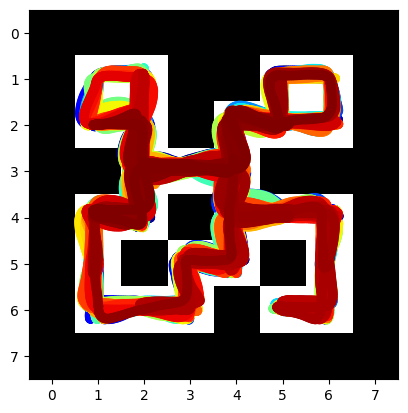

In [5]:
# Medium

# Replace 'your_file_path_here' with the actual path to the HDF5 file
file_path = "/Users/magic-rabbit/Downloads/maze2d-medium-dense-v1.hdf5"
observations, qpos = extract_datasets(file_path)

# Printing shapes of the arrays to confirm extraction
print("Observations shape:", observations.shape)
print("Qpos shape:", qpos.shape)

MEDIUM_MAZE = [
    [1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 1, 1, 0, 0, 1],
    [1, 0, 0, 1, 0, 0, 0, 1],
    [1, 1, 0, 0, 0, 1, 1, 1],
    [1, 0, 0, 1, 0, 0, 0, 1],
    [1, 0, 1, 0, 0, 1, 0, 1],
    [1, 0, 0, 0, 1, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1],
]
background_array = np.array(MEDIUM_MAZE)


plt.clf()
fig = plt.gcf()

plt.imshow(
    background_array,
    cmap=plt.cm.binary,
    # vmin=0,
    # vmax=1,
)

path_length = len(observations)
# observations = observations.reshape(len(observations), -1)
colors = plt.cm.jet(np.linspace(0, 1, 100000))
plt.plot(observations[:100000, 1], observations[:100000, 0], c="black", zorder=10)
plt.scatter(observations[:100000, 1], observations[:100000, 0], c=colors, zorder=20)